In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py
import glob
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib


In [12]:
#veri setinin olduğu path 
train_path = 'C:/Users/user/Desktop/Bitirme/VT/v1/Train'


In [13]:
#colour hşstogram için belirlenen bin sayısı
bins = 8


In [14]:
# feature-extraction-1: Hu Moments-shape information
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [15]:
# feature-extraction-2: Haralick Texture-texture information
def fd_haralick(image):
    # resmin önce gri tonlamalı hale getiriyoruz
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # oluşan gri tonlamalı resmin haralick texture özellik vektörü oluşturulyor
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

In [16]:
# feature-extraction-3: Color Histogram-color information
def fd_histogram(image, mask=None):
    # resim HSV color-space'e dönüştürülüyor
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # renk histogramı hesaplanıyor
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # histogram normalize ediliyor
    cv2.normalize(hist, hist)
    return hist.flatten()

In [17]:
#sınıflar okunuyor dosyadaki
train_labels = os.listdir(train_path)


In [18]:
# okunan sınıflar sıralanıyor
train_labels.sort()
print(train_labels)


['Benign', 'Insitu', 'Invasive', 'Normal']


In [19]:
# özellik vektörünü ve etiket bilgisini tutmak için iki liste oluşturuldu
global_features = []
labels = []

In [20]:
for training_name in train_labels:
    # train dosyasındaki her sınıf için resimler okunuyor
    path = glob.glob("C:/Users/user/Desktop/Bitirme/VT/v1/Train/"+training_name+"/*.tif")
    # training_name sınıf isimlerini tutuyor
    
    #label bilgisi resmin okunduğu sınıf olarak atanıyor
    current_label = training_name
    
    x=0
    # her resim tek tek okunuyor
    for file in path:
        #5800 resim kullanılıyor
        if x<5800:
            image = cv2.imread(file)
            #resim için üç farklı feature extraction yöntemi kullanılıyor
            fv_hu_moments = fd_hu_moments(image)
            fv_haralick   = fd_haralick(image)
            fv_histogram  = fd_histogram(image)
            
            #elde edillen bu üç sonuç birleştiriliyor
            global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
            labels.append(current_label)
            global_features.append(global_feature)

            
            x=x+1
    print ("[STATUS] processed folder: {}".format(current_label))


[STATUS] processed folder: Benign
[STATUS] processed folder: Insitu
[STATUS] processed folder: Invasive
[STATUS] processed folder: Normal


In [21]:
print ("[STATUS] completed Global Feature Extraction...")
# oluşan özellik vektününün boyutu
print ("[STATUS] feature vector size {}".format(np.array(global_features).shape))
print ("[STATUS] training Labels {}".format(np.array(labels).shape))

[STATUS] completed Global Feature Extraction...
[STATUS] feature vector size (5837, 532)
[STATUS] training Labels (5837,)


In [22]:
# label bilgisine encoding yöntemi uygulanıyor
targetNames = np.unique(labels)
le = LabelEncoder()
target = le.fit_transform(labels)
print ("[STATUS] training labels encoded...")

[STATUS] training labels encoded...


In [23]:
# elde edilen feature vector (0,1) arası değerlere scale ediliyor
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print ("[STATUS] feature vector normalized...")

print ("[STATUS] target labels: {}".format(target))
print( "[STATUS] target labels shape: {}".format(target.shape))

[STATUS] feature vector normalized...
[STATUS] target labels: [0 0 0 ... 3 3 3]
[STATUS] target labels shape: (5837,)


In [24]:
# oluşan feature vectorler hdf5 formatında daha sonraki kullanımlar için kaydediliyor
h5f_data = h5py.File('output/data_512.h5', 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label = h5py.File('output/labels_512.h5', 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

In [25]:
#  uygulanan machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=9)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier(random_state=9)))
models.append(('RF', RandomForestClassifier(n_estimators=100, random_state=9)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(kernel='linear')))

In [26]:
# sonuçları ve model isimlerinin tutulması için iki liste
results = []
names = []
scoring = "accuracy"

In [27]:
# oluşturulan feature vector bilgisi okunuyor
h5f_data = h5py.File('output/data_512.h5', 'r')
h5f_label = h5py.File('output/labels_512.h5', 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

In [28]:
# verinin test ve train olarak bölünmesi
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=0.2,
                                                                                          random_state=9)

In [29]:
#train test verilerinin boyutları
print ("[STATUS] splitted train and test data...")
print ("Train data  : {}".format(trainDataGlobal.shape))
print( "Test data   : {}".format(testDataGlobal.shape))
print ("Train labels: {}".format(trainLabelsGlobal.shape))
print ("Test labels : {}".format(testLabelsGlobal.shape))

[STATUS] splitted train and test data...
Train data  : (4669, 532)
Test data   : (1168, 532)
Train labels: (4669,)
Test labels : (1168,)


In [30]:
# filter all the warnings
import warnings
warnings.filterwarnings('ignore')

In [31]:
# 5-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=5, random_state=7)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.650884 (0.015945)
LDA: 0.695860 (0.016889)
KNN: 0.813665 (0.005618)
DTC: 0.778328 (0.008406)
RF: 0.879631 (0.003088)
NB: 0.329619 (0.011057)
SVM: 0.668873 (0.021358)


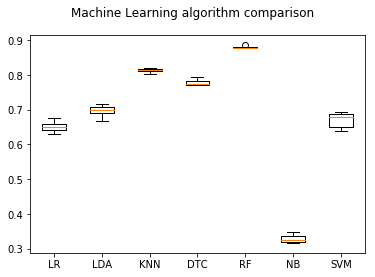

In [32]:
# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [33]:
from sklearn import metrics
for name, model in models:
    clf=model
    clf.fit(trainDataGlobal, trainLabelsGlobal)
    y_pred=clf.predict(testDataGlobal)
    msg = "%s: %f " % (name, metrics.accuracy_score(y_pred,testLabelsGlobal))
    print(msg)

LR: 0.641267 
LDA: 0.702911 
KNN: 0.826199 
DTC: 0.814212 
RF: 0.904110 
NB: 0.343322 
SVM: 0.670377 
